In [2]:
import torch 
from torch import nn
import numpy as np 
from tqdm import tqdm
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from torch.nn import functional as F

In [31]:
def constrained_search(
    n_subjects: int = 1024, 
    p_predicates: int = 1024,
    m_objects_per_predicate: int = 32,
    d_model: int = 16, 
):
    objects = []
    predicates = []
    for _ in range(p_predicates):
        mapping = torch.arange(0, m_objects_per_predicate).repeat(n_subjects // m_objects_per_predicate)
        mapping = mapping[torch.randperm(n_subjects)]
        embs = nn.init.normal_(torch.zeros(m_objects_per_predicate, d_model // 2))
        predicates.append(mapping)
        objects.append(embs[mapping])
    
    # y = nn.init.normal_(torch.zeros(n_subjects, d_model)).to(device)
    xs, ys = [], []
    for i in range(p_predicates):
        for j in range(i + 1, p_predicates):
            for k in range(m_objects_per_predicate):
                for l in range(m_objects_per_predicate):
                    xs.append(torch.concat([objects[i][k], objects[j][l]], dim=-1))
                    ys.append(int(((predicates[i] == k) & (predicates[j] == l)).any()))
    x = torch.stack(xs, dim=0)
    y = torch.tensor(ys)

    return x, y
x, y = constrained_search(
    n_subjects=32,
    p_predicates=32,
    m_objects_per_predicate=8,
    d_model=12,
)

In [32]:
y.float().mean()

tensor(0.4313)

In [33]:
class Model(nn.Module):


    def forward(self, x):
        raise NotImplementedError

    def loss(self, x: torch.Tensor, y: torch.Tensor):
        raise NotImplementedError

    def metrics(self, output: torch.Tensor, y:torch.Tensor): 
        return {}


def mapping(num_kv_pairs: int = 1024, d_model: int= 16, device: int = 0):
    keys = torch.tensor(np.random.choice(num_kv_pairs,num_kv_pairs, replace=False))
    values = torch.tensor(np.random.choice(num_kv_pairs,num_kv_pairs, replace=False))
    embs = nn.init.normal_(torch.zeros(num_kv_pairs, d_model))
    return embs[keys].to(device), embs[values].to(device)

    
def fit_model(
    x: torch.Tensor,
    y: torch.Tensor,
    pbar: bool = False, 
    num_epochs: int = 3_000,
    log_interval: int = 200,
    device: int = 0, 
    model_cls: type = Model,
    **kwargs
):
    d_model = x.shape[-1]
    model = model_cls(d_model=d_model, **kwargs)
    model.to(device)
    x = x.to(device)
    y = y.to(device)

    # Define a loss function and an optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    # Training loop
    metrics = []
    for epoch in tqdm(range(num_epochs), disable=not pbar):  # 500 epochs
        optimizer.zero_grad()   # zero the gradient buffers
        loss, output, meta = model.loss(x, y)    # Forward pass
        loss.backward()  # Backward pass
        optimizer.step()  # Does the update

        if epoch % log_interval == 0:
            metrics.append({
                'epoch': epoch,
                'loss': loss.item(),
                **model.metrics(output, y)
            })
    return metrics[-1], metrics, meta, model

In [34]:
class ExistenceModel(Model):
    def __init__(self, d_model: int = 16, activation: callable = torch.relu):
        super().__init__()
        # self.embeddings.weight.data = torch.eye(num_kv_pairs, d_model)
        self.layer1 = nn.Linear(d_model, d_model, bias=True)
        self.layer2 = nn.Linear(d_model, 2, bias=True)
        self.activation = activation

    def forward(self, x):
        x1 = self.activation(self.layer1(x))
        y = self.layer2(x1)
        return y, {"x1": x1}

    def loss(self, x: torch.Tensor, y: torch.Tensor):
        output, meta = self(x)
        loss = F.cross_entropy(output, y)
        return loss, output, meta

    def metrics(self, output: torch.Tensor, y: torch.Tensor):
        return {
            "accuracy": (
                output.argmax(dim=1) == torch.arange(y.shape[0], device=y.device)
            )
            .float()
            .mean()
            .item()
        }
    
class MappingModel(Model):
    def __init__(self, d_model: int = 16, activation: callable = torch.relu):
        super().__init__()
        # self.embeddings.weight.data = torch.eye(num_kv_pairs, d_model)
        self.layer1 = nn.Linear(d_model, d_model, bias=True)
        self.layer2 = nn.Linear(d_model, d_model, bias=True)
        self.activation = activation

    def forward(self, x):
        x1 = self.activation(self.layer1(x))
        y = self.layer2(x1)
        return y, {"x1": x1}

    def loss(self, x: torch.Tensor, y: torch.Tensor):
        output, meta = self(x)
        preds = output @ y.T
        loss = F.cross_entropy(preds, torch.arange(y.shape[0], device=y.device))
        return loss, output, meta

    def metrics(self, output: torch.Tensor, y: torch.Tensor):
        preds = output @ y.T
        return {
            "accuracy": (
                preds.argmax(dim=1) == torch.arange(y.shape[0], device=y.device)
            )
            .float()
            .mean()
            .item()
        }
    
class ConstrainedSearchModel(Model):
    def __init__(self, d_model: int = 16, activation: callable = torch.relu):
        super().__init__()
        # self.embeddings.weight.data = torch.eye(num_kv_pairs, d_model)
        self.layer1 = nn.Linear(d_model, d_model * 2, bias=True)
        self.layer2 = nn.Linear(d_model * 2, d_model, bias=True)
        self.activation = activation

    def forward(self, x):
        x1 = self.activation(self.layer1(x))
        y = self.layer2(x1)
        return y, {"x1": x1}

    def loss(self, x: torch.Tensor, y: torch.Tensor):
        output, meta = self(x)
        preds = output @ y.T
        loss = F.cross_entropy(preds, torch.arange(y.shape[0], device=y.device))
        return loss, output, meta

    def metrics(self, output: torch.Tensor, y: torch.Tensor):
        preds = output @ y.T
        return {
            "accuracy": (
                preds.argmax(dim=1) % y.shape[0] == torch.arange(y.shape[0], device=y.device)
            )
            .float()
            .mean()
            .item()
        }

In [145]:
from sklearn.metrics import roc_auc_score

class ExistenceModel(Model):
    def __init__(self, d_model: int = 16, activation: callable = torch.relu):
        super().__init__()
        # self.embeddings.weight.data = torch.eye(num_kv_pairs, d_model)
        self.layer1 = nn.Linear(d_model, d_model, bias=True)
        self.layer2 = nn.Linear(d_model, 1, bias=True)
        self.activation = activation

    def forward(self, x):
        x1 = self.activation(self.layer1(x))
        y = self.layer2(x1)
        return y.squeeze(-1), {"x1": x1}

    def loss(self, x: torch.Tensor, y: torch.Tensor):
        output, meta = self(x)
        loss = F.binary_cross_entropy_with_logits(output, y.to(float))
        return loss, output, meta

    def metrics(self, output: torch.Tensor, y: torch.Tensor):
        return {
            "auroc": roc_auc_score(y.cpu().detach().to(int), output.cpu().detach())
        }

def constrained_existence_search(
    n_subjects: int = 1024, 
    p_predicates: int = 1024,
    m_objects_per_predicate: int = 4,
    d_model: int = 16, 
):
    objects = []
    predicates = []
    for _ in range(p_predicates):
        mapping = torch.arange(0, m_objects_per_predicate).repeat(n_subjects // m_objects_per_predicate)
        mapping = mapping[torch.randperm(n_subjects)]
        embs = nn.init.normal_(torch.zeros(m_objects_per_predicate, d_model // 2))
        predicates.append(mapping)
        objects.append(embs)    
    
    # y = nn.init.normal_(torch.zeros(n_subjects, d_model)).to(device)
    xs, ys = [], []
    for i in range(p_predicates):
        for j in range(i + 1, p_predicates):
            for k in range(m_objects_per_predicate):
                for l in range(m_objects_per_predicate):
                    xs.append(torch.concat([objects[i][k], objects[j][l]], dim=-1))
                    ys.append(int(((predicates[i] == k) & (predicates[j] == l)).any()))
    x = torch.stack(xs, dim=0)
    y = torch.tensor(ys)

    return x, y
x, y = constrained_existence_search(
    n_subjects=16,
    p_predicates=16,
    m_objects_per_predicate=4,
    d_model=6,
)

In [146]:
x

tensor([[-0.8397, -0.9674,  0.9011, -0.9534,  0.8404, -0.7614],
        [-0.8397, -0.9674,  0.9011,  0.7813,  0.8608,  0.9452],
        [-0.8397, -0.9674,  0.9011, -0.3614, -0.1086,  0.3398],
        ...,
        [ 0.6707,  0.0998, -0.4071,  0.8998, -0.6889, -0.4828],
        [ 0.6707,  0.0998, -0.4071, -0.2029,  0.5876,  0.2105],
        [ 0.6707,  0.0998, -0.4071, -1.7815,  1.2952, -0.0725]])

In [112]:
torch.randperm(10)

tensor([5, 3, 7, 1, 6, 2, 8, 9, 0, 4])

In [106]:
y

tensor([0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [127]:
# num_kv_pairs_list = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
# num_kv_pairs_list = [131072]
import math


n_list = [16]

d_model_list = [16, 32, 64, 128, 256, 512, 1024, 2048]
d_model_list = [4096]
# d_model_list = [16, 32, 64, 128]
results = []

for n in tqdm(n_list, desc='num_kv_pairs loop', position=0, disable=True):
    for d_model in tqdm(d_model_list, desc='d_model loop', position=1, disable=True):
      
        x, y = constrained_search(
            n_subjects=n, 
            p_predicates=n,
            m_objects_per_predicate=int(math.sqrt(n)),
            d_model=d_model, 
        )
      
        metrics, _, _, _ = fit_model(
            x, y,
            num_epochs=2048,
            log_interval=200,
            device="cuda", 
            model_cls=ExistenceModel,
            pbar=True
        )
        results.append(
            {
                'n': n,
                'd_model': d_model,
                **metrics
            }
        )


100%|██████████| 2048/2048 [00:14<00:00, 138.32it/s]


In [136]:
a, b = torch.where((x[:, None, :] == x[None, :, :]).all(dim=-1))

In [141]:
(y[a] == y[b]).float().mean()

tensor(0.7329)

In [129]:
df = pd.DataFrame(results)

In [130]:
df

,n,d_model,epoch,loss,auroc
0,16,4096,2000,0.305322,0.901726


In [22]:
# num_kv_pairs_list = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
# num_kv_pairs_list = [131072]
import math


n_list = [64, 256, 1024, 4096]

d_model_list = [16, 32, 64, 128, 256, 512]
# d_model_list = [16, 32, 64, 128]
results = []
for task in [
    # 'set_intersection', 
    # 'mapping', 
    # 'constrained_search',
    ''

]:
    for n in tqdm(n_list, desc='num_kv_pairs loop', position=0):
        for d_model in tqdm(d_model_list, desc='d_model loop', position=1, leave=False):
            if task == "constrained_search":
                x, y = constrained_search(
                    n=n, 
                    m=int(math.sqrt(n)),
                    d_model=d_model, 
                )
            elif task == "mapping":
                x, y = mapping(
                    num_kv_pairs=n,
                    d_model=d_model
                )
            elif task == "set_intersection":
                x, y = set_intersection(
                    n_entities=n,
                    n_sets=4, 
                    m=int(math.sqrt(n)),
                    d_model=d_model,
                )
            else:
                raise ValueError(f"Unknown task {task}")
            metrics, _, _, _ = fit_model(
                x, y,
                num_epochs=864,
                log_interval=200,
                device="cuda", 
                model_cls=ExistenceModel,
                pbar=False
            )
            results.append(
                {
                    'n': n,
                    'd_model': d_model,
                    'task': task,
                    **metrics
                }
            )


num_kv_pairs loop:   0%|          | 0/4 [00:00<?, ?it/s]

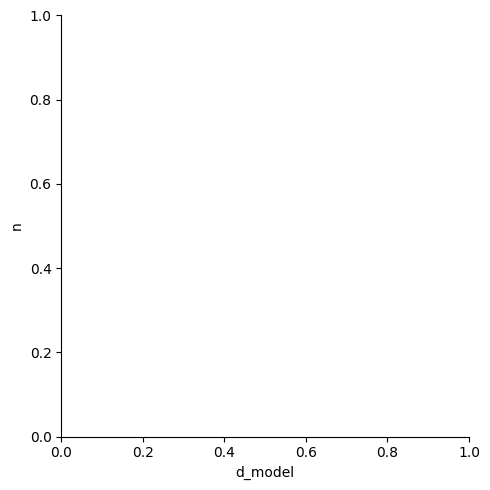

In [18]:
df = pd.DataFrame(results)

threshold = 0.95
df["passes"] = df['accuracy'] > threshold
plot_df = df[df["passes"]].groupby(["n", "task"])["d_model"].min().reset_index()
sns.relplot(data=plot_df, y="n", x="d_model", hue="task",kind="line", marker="o")


In [19]:
df

,n,d_model,task,epoch,loss,accuracy,passes
0,64,16,set_intersection,800,4.556958,0.036458,False
1,64,32,set_intersection,800,2.405154,0.127604,False
2,64,64,set_intersection,800,2.320300,0.111979,False
3,64,128,set_intersection,800,2.296498,0.111979,False
4,64,256,set_intersection,800,2.295425,0.117188,False
5,64,512,set_intersection,800,2.263717,0.114583,False
6,256,16,set_intersection,800,6.960930,0.004557,False
7,256,32,set_intersection,800,5.736649,0.022135,False
8,256,64,set_intersection,800,2.549113,0.109375,False
9,256,128,set_intersection,800,2.371179,0.112630,False
